In [2]:
import numpy as np
import matplotlib.pyplot as plt
import ephem 
from simons_array_python.calibration.planet import ephem_planet
from simons_array_python import sa_ephem as sa_ephem
import toast.qarray as qa
from simons_array_python import sa_sql
from toast.tod.sim_focalplane import cartesian_to_quat
import healpy as hp

INFO: sqlite database /data/pb2/ChileData/databases/pb2a-20220405_benchmark_dataset/pb2a_runid.db attached.
INFO: sqlite database /data/pb2/ChileData/databases/pb2a-20220405_benchmark_dataset/pb2a_runid_g3.db attached.
INFO: sqlite database /data/pb2/ChileData/databases/pb2a-20220405_benchmark_dataset/pb2a_data_quality.db attached.
INFO: sqlite database /data/pb2/ChileData/databases/pb2a-20220405_benchmark_dataset/pb2a_mapping.db attached.
INFO: sqlite database /data/pb2/ChileData/databases/pb2a-20220405_benchmark_dataset/pb2a_monitor.db attached.
INFO: sqlite database /data/pb2/ChileData/databases/pb2a-20220405_benchmark_dataset/pb2a_stim_template.db attached.
INFO: sqlite database /data/pb2/ChileData/databases/pb2a-20220405_benchmark_dataset/pb2a_stim_iq.db attached.
INFO: numpy.fft used.


/opt/pkgs/spt3g_software_sa_2019-05-13/build/spt3g/gcp/ARCExtractor.py:11: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if uname is not 'None':








## Method 1: Convert boresight az/el to ra/dec with Toast quaternion function 
### Based entirely off of https://github.com/hpc4cmb/toast/blob/b780cd5c4529f8675519e66fa5231aa1f45dbfe2/src/toast/todmap/sim_tod.py#L1624

In [3]:
def get_boresight_quats(times, az, el):
    # get quaternions representing the boresight pointing in azimuth/elevation
    observer = ephem_planet.pb2a_site()
    observer.pressure = 0
    
    azel_quats = qa.from_angles(
        np.pi/2 - el,
        -1.*az,
        np.zeros(len(times))
    )

    lasttime = times[-1]
    firsttime = times[0]

#     #Get one every 2 minutes
    n = max(2, 1 + int((lasttime - firsttime)* 86400/ 120))
    my_times = np.linspace(firsttime, lasttime, n)

    # compute rotation quaternions from az/el to ra/dec
    azel2radec_quats = np.zeros([n, 4])
    for i, t in enumerate(my_times):
        azel2radec_quats[i] = _get_conversion_quat(t, observer)

        # make sure we have a consistent branch
        if i > 0 and (np.sum(np.abs(azel2radec_quats[i-1] + azel2radec_quats[i]))
                      < np.sum(np.abs(azel2radec_quats[i-1] - azel2radec_quats[i]))):
            azel2radec_quats[i] *= -1

    azel2radec_quats = qa.norm(azel2radec_quats)

    azel2radec_quats = qa.slerp(times, my_times, azel2radec_quats)
    # multiply quaternions to get the boresight pointing in equatorial coordinates
    boresight_quats = qa.mult(azel2radec_quats, azel_quats)
    del azel2radec_quats

    return azel_quats, boresight_quats

def _get_conversion_quat(t, observer):
    observer.date = ephem_planet.mjd_to_djd(t)

    xra, xdec = observer.radec_of(0, 0)
    yra, ydec = observer.radec_of(-np.pi/2, 0)
    zra, zdec = observer.radec_of(0, np.pi/2)

    xvec, yvec, zvec = hp.ang2vec(np.pi/2 - np.array([xdec, ydec, zdec]),
                               np.array([xra, yra, zra]))

    # Orthonormalize for numerical stability
    xvec /= np.sqrt(np.dot(xvec, xvec))
    yvec -= np.dot(xvec, yvec) * xvec
    yvec /= np.sqrt(np.dot(yvec, yvec))
    zvec -= np.dot(xvec, zvec) * xvec + np.dot(yvec, zvec) * yvec
    zvec /= np.sqrt(np.dot(zvec, zvec))

    # Solve for the quaternions from the transformed axes.
    X = (xvec[1] + yvec[0]) / 4
    Y = (xvec[2] + zvec[0]) / 4
    Z = (yvec[2] + zvec[1]) / 4

    d = np.sqrt(np.abs(Y * Z / X)) # Choose positive root
    c = d * X / Y
    b = X / c
    a = (xvec[1]/2 - b*c) / d
    # qarray has the scalar part as the last index
    quat = qa.norm(np.array([b, c, d, a]))
    # DEBUG begin
    errors = np.array([
        np.dot(qa.rotate(quat, [1, 0, 0]), xvec),
        np.dot(qa.rotate(quat, [0, 1, 0]), yvec),
        np.dot(qa.rotate(quat, [0, 0, 1]), zvec)])
    errors[errors > 1] = 1
    errors = np.degrees(np.arccos(errors))
    if np.any(errors > 1) or np.any(np.isnan(errors)):
        raise RuntimeError('Quaternion is not right: ({}), ({} {} {})'
                           ''.format(errors, X, Y, Z))
    # DEBUG end
    return quat

## Method 2: Convert boresight az/el to ra/dec with Pyephem method

In [8]:
#Convert Az/El to RA/dec using ephem
def azel_to_radecpa(mjd, az, el):
        observer = ephem_planet.pb2a_site()
        observer.pressure = 0
        ra, dec, pa = [], [], []
        for t, a, e in zip(mjd, az, el):
            observer.date = ephem_planet.mjd_to_djd(t)
            r, d = observer.radec_of(a, e)
            obj = ephem.FixedBody()
            obj._ra, obj._dec = r, d
            obj.compute(observer)
            ra.append(r)
            dec.append(np.pi/2-d)
            pa.append(-obj.parallactic_angle())
        return np.array(ra), np.array(dec), np.array(pa)

## Load some az/el, times (in MJD) vectors from a data run

In [9]:
times = np.load('bolo_time.npy')
az = np.load('az.npy')
el = np.load('el.npy')

## Method 1: Compute the boresight quaternion in ra/dec with the Toast method and turn it into angles

In [10]:
azel_quats, boresight_quats = get_boresight_quats(times, az, el) 
theta_boresight, phi_boresight, pos_boresight = qa.to_angles(boresight_quats)

## Method 2: Compute boresight ra/dec/pa with the Pyephem method

In [11]:
ra_boresight, dec_boresight, pa_boresight = azel_to_radecpa(times, az , el) 

## Print the average error between the two methods and plot
### Although the plots look close, the average error is non-neglibible especially for position angle :'(

Average errors in degrees 0.007604209907513437 0.00832456013106743 0.23054277223575603


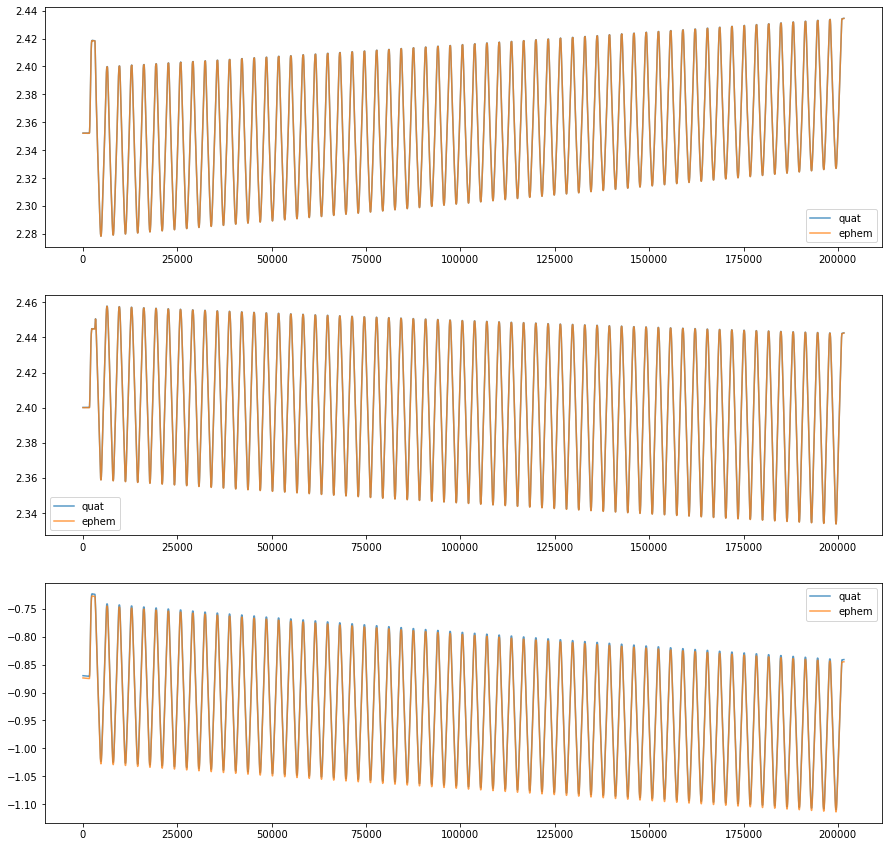

In [12]:
print('Average errors in degrees',
    np.rad2deg(np.mean(phi_boresight-ra_boresight)),
    np.rad2deg(np.mean(theta_boresight-dec_boresight)),
    np.rad2deg(np.mean(pos_boresight-pa_boresight))
)

fig, axes = plt.subplots(3, figsize=(15,15))

axes[0].plot(phi_boresight, label='quat', alpha=0.75)
axes[0].plot(ra_boresight, label='ephem', alpha=0.75)
axes[0].legend()

axes[1].plot(theta_boresight, label='quat', alpha=0.75)
axes[1].plot(dec_boresight, label='ephem', alpha=0.75)
axes[1].legend()

axes[2].plot(pos_boresight, label='quat', alpha=0.75)
axes[2].plot(pa_boresight, label='ephem', alpha=0.75)
axes[2].legend()

In [44]:
# def plot_results(det=None, det_offset_x=None, det_offset_y=None):
#     #Calculate det pntg with quats
#     if det is not None:
#         det_offset_x = sa_sql.db_impl.focalplane_db[det].det_offset_x
#         det_offset_y = sa_sql.db_impl.focalplane_db[det].det_offset_y
    
#     print(
#         'Detector offsets x/y in degrees:',
#         det_offset_x, 
#         det_offset_y)
        
#     det_offset_quat = cartesian_to_quat([[-det_offset_y, -det_offset_x, 0]])[0]
#     det_pntg = qa.mult(boresight, det_offset_quat)
#     theta, phi, pos = qa.to_angles(det_pntg)
    
#     #Calculate det pntg with flat sky
#     ra, dec, pa = azel_to_radecpa(times, az-(np.deg2rad(det_offset_x)/np.cos(el)) , el-np.deg2rad(det_offset_y)) 
    
#     #Plot phi with RA, dec with theta, etc
#     fig, axes = plt.subplots(3, figsize=(15,15))
    
#     axes[0].plot(ra_boresight, label='boresight', alpha=0.75)    
#     axes[0].plot(ra, label='flat', alpha=0.75)
#     axes[0].plot(phi, label='quat', alpha=0.75)
#     axes[0].legend()
    
#     axes[1].plot(dec_boresight, label='boresight', alpha=0.75)    
#     axes[1].plot(dec, label='flat', alpha=0.75)
#     axes[1].plot(theta, label='quat', alpha=0.75)
#     axes[1].legend()
    
#     axes[2].plot(pa_boresight, label='boresight', alpha=0.75)    
#     axes[2].plot(pa, label='flat', alpha=0.75)
#     axes[2].plot(pos, label='quat', alpha=0.75)
#     axes[2].legend()
    
#     plt.show()
    
#     print('Average errors in degrees',
#         np.rad2deg(np.mean(phi-ra)),
#         np.rad2deg(np.mean(theta-dec)),
#         np.rad2deg(np.mean(pos-pa))
#     )


In [ ]:
# det_far = '13.11_267.90B'
# det_close = '13.13_220.90T'

In [ ]:
# plot_results(det_close)

In [ ]:
# plot_results(det_far)